Text(0.5, 1.0, 'Validation')

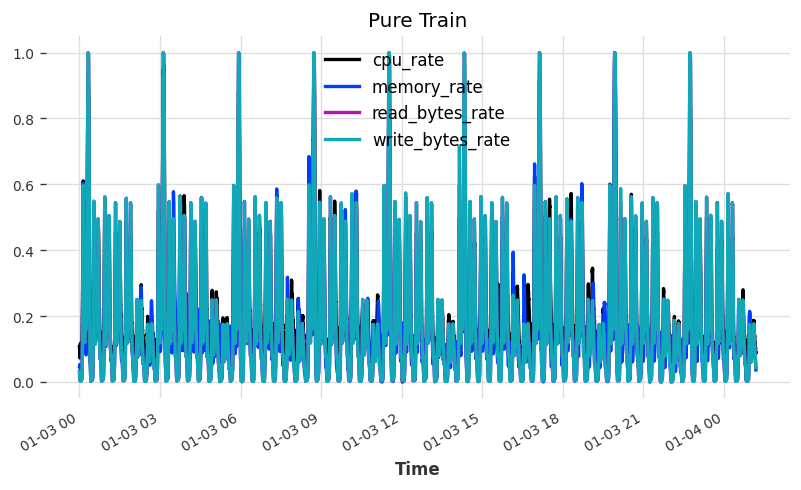

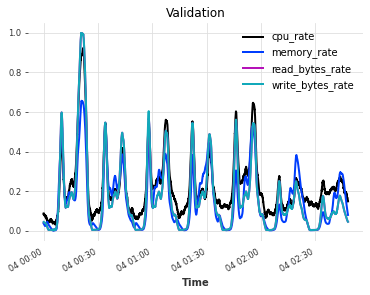

In [4]:
import torch
import numpy as np
seed = 37
torch.manual_seed(seed)
np.random.seed(seed)

import sys
sys.path.append("../../")
from pipeline.dataset.dataset_loader import DatasetLoader
import pandas as pd
from darts.models import (
    BlockRNNModel,
)
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
import matplotlib.pyplot as plt
from darts.metrics import rho_risk
import matplotlib.pyplot as plt
import tsaug
import ray
from ray import tune
import os
from matplotlib.pyplot import figure

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["LD_LIBRARY_PATH"] = "/home/jupyter-babakesistani/.conda/envs/thesis/lib/"

figure(figsize=(8, 4), dpi=120)


dl =  DatasetLoader( '../../pipeline/data/cpu_memory_disk_23_march.csv', "Time",
                                                                    [
                                                                      "cpu_rate",
                                                                      "memory_rate",
                                                                      "read_bytes_rate",
                                                                      "write_bytes_rate"
                                                                     ],
                    resample_freq="1s", augment=False, shift_df_datetime="2022-01-03 00:00:00")
scaled_one_day = 24*60
scaled_one_week = 7*24*60
idx_first = 9*scaled_one_week
train = dl.series_scaled[:idx_first]
val = dl.series_scaled[idx_first:]
# train , val=  dl.get_train_val_by_date(train_end="2022-01-07 00:00:00")
# val = val[:-1]
# tmp_train = train.copy()
# for _ in range(6):
#     train = dl.series_append(train, tmp_train)
    
# train = dl.simple_add_augment(train, -0.01, 0.025, 0.005)

    
train.plot()
plt.title("Pure Train")
val = dl.shift_series_to(val, "2022-04-04 00:00:00")

val.plot(new_plot=True)
plt.title("Validation")



In [5]:
def generate_encoders(idxs):
    days = ((idxs.second + idxs.minute*60 + idxs.hour*60*60 + idxs.dayofweek*24*60*60) // (24*60)) % 7
    encoders = []
    for day in days:
        if day == 0:
            encoders.append(1)
        elif day == 1 or day == 2 or day == 3 or day == 4: 
            encoders.append(2)
        elif day == 5 or day == 6:
            encoders.append(3)
    return encoders

In [6]:
quantiles = [0.1, 0.5, 0.9]

model = BlockRNNModel(
    model="LSTM",
    input_chunk_length=300,
    output_chunk_length=600,
    hidden_size=25,
    n_rnn_layers=2,
    batch_size=512,
    n_epochs=10,
    dropout=0.1,
    save_checkpoints=True,
    model_name="LSTM",
     add_encoders={
    'cyclic': {'past': ['dayofweek', 'hour', 'minute', 'second']},
#     'custom': {'past': [generate_encoders]},
    'custom': {'past': [generate_encoders]},
#     "position": {"past": ["relative"]},
    'transformer': Scaler()
    },
    likelihood=QuantileRegression(
        quantiles=quantiles
    ), 
    work_dir="logs/lstm_nohparam",
    nr_epochs_val_period=1,
    optimizer_kwargs={"lr": 1e-3},
    log_tensorboard=True,
    random_state=42,
    force_reset=True,
    torch_device_str='cuda:0'
)

In [ ]:
model.fit(train, val_series=val, verbose=True)

[2022-05-01 14:21:40,951] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 89821 samples.
[2022-05-01 14:21:40,951] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 89821 samples.
[2022-05-01 14:21:40,958] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-05-01 14:21:40,958] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
def merge_prediction_fetched_series(prediction, fetched_series) :
        if len(fetched_series.columns) == len(prediction.columns):
            return fetched_series

        if prediction.start_time() != fetched_series.start_time():
            print("prediction and fetched series start time are different: " \
                            + str(prediction.start_time()) + "<>" + str(fetched_series.start_time()))
            raise NotImplementedError
        
        if prediction.end_time() < fetched_series.end_time():
            raise NotImplementedError

        prediction_components = prediction.components.to_list()
        fetched_series_components = fetched_series.components.to_list()
        diff_components = list(set(prediction_components) - set(fetched_series_components))
        prediction_diff_series = prediction[diff_components].slice(fetched_series.start_time(),
                                                                   fetched_series.end_time())
        return prediction_diff_series.concatenate(fetched_series, axis=1)

In [ ]:
def get_cols_to_fetch( prediction, std_threshold):
    cols_to_fetch = []
    for i, component in enumerate(prediction.components):
        pred = prediction.univariate_component(i)
        pred = pred.all_values()  # Time X Components X samples
        pred = np.squeeze(pred)  # Time X samples
        std = np.mean(np.std(pred, axis=1))
        if std > std_threshold:
            print("Component: " + str(component) + " has std value more than threshold:"
                            + str(std_threshold) + "std: " + str(std))
            cols_to_fetch.append(component)
        else:
            print("Component: " + str(component) + " has std value less than threshold:"
                          + str(std_threshold) + "std: " + str(std))
    return cols_to_fetch

In [10]:
len(val.columns)

4

In [14]:
fetch_len = 300
pred_len = 600
last_fetch_len = 0
len_val = len(val)
len_cols = len(val.columns)
series_to_predict = val[last_fetch_len:last_fetch_len+fetch_len]
last_fetch_len = last_fetch_len+fetch_len
#already fetched one series 
num_cols_fetched = len_cols
num_cols_predicted = 0
fetched_pred_num = num_cols_fetched + num_cols_predicted
while(last_fetch_len+pred_len < len_val):
    pred = model.predict(series=series_to_predict, n=pred_len, num_samples=100)
    cols_to_fetch = get_cols_to_fetch (pred, 0.07)
    single_prediction =  model.predict(series=series_to_predict, n=pred_len)
    if not cols_to_fetch:
        series_to_predict = single_prediction
        last_fetch_len = last_fetch_len + pred_len
        num_cols_predicted+=len_cols
        continue
    num_cols_fetched+=len(cols_to_fetch)
    num_cols_predicted+=len_cols-len(cols_to_fetch)
    fetched_series = val[cols_to_fetch][last_fetch_len:last_fetch_len + pred_len]
    last_fetch_len = last_fetch_len + pred_len
    series_to_predict = merge_prediction_fetched_series(single_prediction, fetched_series)

Component: cpu_rate has std value less than threshold:0.07std: 0.04881647507251402
Component: memory_rate has std value less than threshold:0.07std: 0.04695580783446993
Component: read_bytes_rate has std value less than threshold:0.07std: 0.0607504698016418
Component: write_bytes_rate has std value less than threshold:0.07std: 0.06118042829608697
Component: cpu_rate has std value more than threshold:0.07std: 0.10523930073027929
Component: memory_rate has std value more than threshold:0.07std: 0.09526965158445776
Component: read_bytes_rate has std value more than threshold:0.07std: 0.1289994164447564
Component: write_bytes_rate has std value more than threshold:0.07std: 0.13026280633613616
Component: cpu_rate has std value less than threshold:0.07std: 0.05939222508791735
Component: memory_rate has std value less than threshold:0.07std: 0.05807539090883014
Component: read_bytes_rate has std value more than threshold:0.07std: 0.07220149535037834
Component: write_bytes_rate has std value m

In [ ]:
last_fetch_len

In [15]:
num_cols_fetched

12

In [16]:
num_cols_predicted

56

In [17]:
56/68

0.8235294117647058

In [12]:
pred = model.predict(series=val[:cut_off], n=pred_len, num_samples=500)
for i in range(pred.n_components):
    pred.univariate_component(i)

NameError: name 'model' is not defined

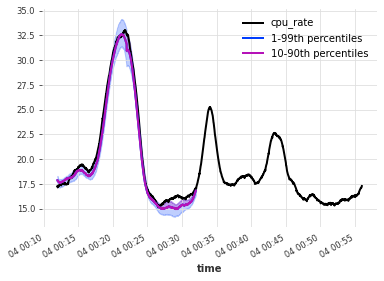

<Figure size 960x480 with 0 Axes>

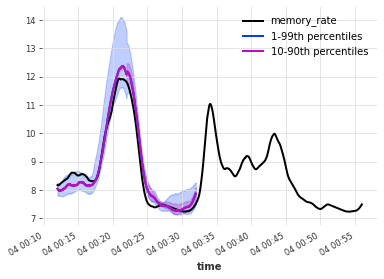

<Figure size 960x480 with 0 Axes>

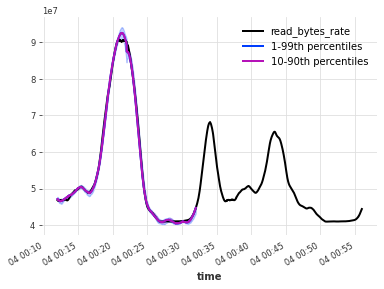

<Figure size 960x480 with 0 Axes>

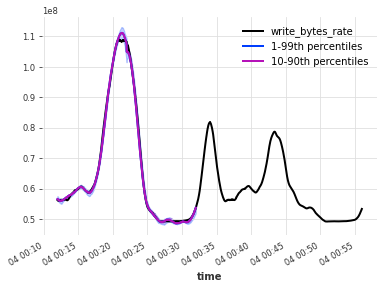

<Figure size 960x480 with 0 Axes>

In [13]:
cut_off = 1440//2
pred_len = 1200
pred = model.predict(series=val[:cut_off], n=pred_len, num_samples=500)
pred = dl.scaler.inverse_transform(pred)
val_back = dl.scaler.inverse_transform(val)
for i in range(pred.n_components):
    val_back[cut_off:cut_off+pred_len+1440].univariate_component(i).plot()
    pred.univariate_component(i).plot(low_quantile=0.05, high_quantile=0.95, label="1-99th percentiles")
    pred.univariate_component(i).plot(low_quantile=0.1, high_quantile=0.9,  label="10-90th percentiles")
    figure(figsize=(8, 4), dpi=120)
    plt.savefig(str(i))
    plt.show()

In [16]:
best_model = model.load_from_checkpoint(model_name="2022-03-25_16.42.15.180473_torch_model_run_571329"
                                        ,work_dir="logs/lstm_nohparam", best=True)


[2022-03-26 12:35:05,053] INFO | darts.models.forecasting.torch_forecasting_model | loading model_best_185.pth.tar
[2022-03-26 12:35:05,053] INFO | darts.models.forecasting.torch_forecasting_model | loading model_best_185.pth.tar


In [85]:
print(best_model.to("cpu"))

AttributeError: 'BlockRNNModel' object has no attribute 'to'

In [18]:
best_model.save_model("saved_models/lstm_300_600.pth.tar")

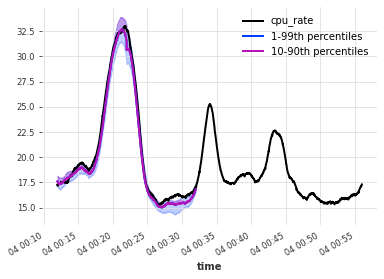

<Figure size 960x480 with 0 Axes>

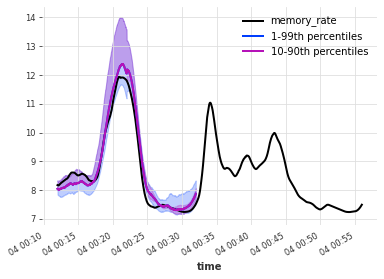

<Figure size 960x480 with 0 Axes>

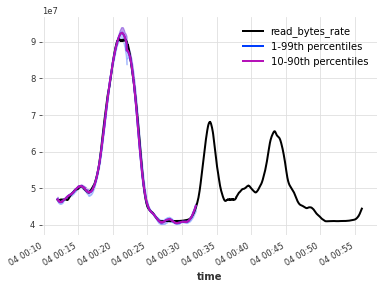

<Figure size 960x480 with 0 Axes>

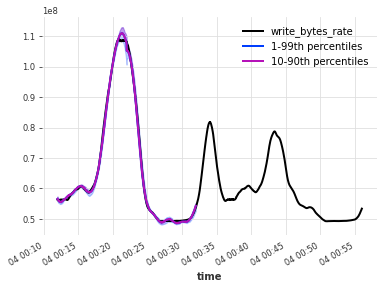

<Figure size 960x480 with 0 Axes>

In [17]:
cut_off = 1440//2
pred_len = 1200
pred = best_model.predict(series=val[:cut_off], n=pred_len, num_samples=500)
pred = dl.scaler.inverse_transform(pred)
val_back = dl.scaler.inverse_transform(val)
for i in range(pred.n_components):
    val_back[cut_off:cut_off+pred_len+1440].univariate_component(i).plot()
    pred.univariate_component(i).plot(low_quantile=0.05, high_quantile=0.95, label="1-99th percentiles")
    pred.univariate_component(i).plot(low_quantile=0.1, high_quantile=0.9,  label="10-90th percentiles")
    figure(figsize=(8, 4), dpi=120)
    plt.savefig(str(i))
    plt.show()

In [19]:
pred

<TimeSeries (DataArray) (time: 1200, component: 4, sample: 500)>
array([[[1.81754213e+01, 1.76006731e+01, 1.81754213e+01, ...,
         1.81754213e+01, 1.76006731e+01, 1.81754213e+01],
        [8.34075040e+00, 8.04368434e+00, 8.34075040e+00, ...,
         8.34075040e+00, 8.04368434e+00, 8.34075040e+00],
        [4.76864712e+07, 4.69734789e+07, 4.76864712e+07, ...,
         4.76864712e+07, 4.69734789e+07, 4.76864712e+07],
        [5.73850286e+07, 5.65573637e+07, 5.73850286e+07, ...,
         5.73850286e+07, 5.65573637e+07, 5.73850286e+07]],

       [[1.81355530e+01, 1.75708051e+01, 1.81355530e+01, ...,
         1.81355530e+01, 1.75708051e+01, 1.81355530e+01],
        [8.32144873e+00, 8.03599318e+00, 8.32144873e+00, ...,
         8.32144873e+00, 8.03599318e+00, 8.32144873e+00],
        [4.75351711e+07, 4.69594319e+07, 4.75351711e+07, ...,
         4.75351711e+07, 4.69594319e+07, 4.75351711e+07],
        [5.72302164e+07, 5.65060791e+07, 5.72302164e+07, ...,
         5.72302164e+07, 5.65060791e+07, 5.72302164e+07]],

       [[1.81480486e+01, 1.75652185e+01, 1.81480486e+01, ...,
         1.81480486e+01, 1.75652185e+01, 1.81480486e+01],
...
        [5.39972875e+07, 5.40092537e+07, 5.39972875e+07, ...,
         5.39972875e+07, 5.40092537e+07, 5.39972875e+07]],

       [[1.69285860e+01, 1.67685582e+01, 1.69285860e+01, ...,
         1.69285860e+01, 1.67685582e+01, 1.69285860e+01],
        [7.71248778e+00, 7.85555900e+00, 7.71248778e+00, ...,
         7.71248778e+00, 7.85555900e+00, 7.71248778e+00],
        [4.50520925e+07, 4.50705845e+07, 4.50520925e+07, ...,
         4.50520925e+07, 4.50705845e+07, 4.50520925e+07],
        [5.41552909e+07, 5.41732171e+07, 5.41552909e+07, ...,
         5.41552909e+07, 5.41732171e+07, 5.41552909e+07]],

       [[1.69768336e+01, 1.68163771e+01, 1.69768336e+01, ...,
         1.69768336e+01, 1.68163771e+01, 1.69768336e+01],
        [7.72996309e+00, 7.87325643e+00, 7.72996309e+00, ...,
         7.72996309e+00, 7.87325643e+00, 7.72996309e+00],
        [4.51279165e+07, 4.51471235e+07, 4.51279165e+07, ...,
         4.51279165e+07, 4.51471235e+07, 4.51279165e+07],
        [5.42409880e+07, 5.42568760e+07, 5.42409880e+07, ...,
         5.42409880e+07, 5.42568760e+07, 5.42409880e+07]]])
Coordinates:
  * time       (time) datetime64[ns] 2022-04-04T00:12:00 ... 2022-04-04T00:31:59
  * component  (component) object 'cpu_rate' ... 'write_bytes_rate'
Dimensions without coordinates: sample

In [61]:
pred = dl.scaler.inverse_transform(pred)

In [19]:
quantiles = [0.1, 0.5, 0.9]

pred = model.predict(series=val[:300], n=1440 ,num_samples=100)
rr = 0.0
for rho in quantiles:
    rr += rho_risk(val[300:], pred, rho=rho)
rr = rr / len(quantiles)
    

In [20]:
rr

0.01920877554173023

In [79]:
pred.time_index.shift(freq=-1*pd.Timedelta("1 day"))

DatetimeIndex(['2022-04-03 00:12:00', '2022-04-03 00:12:01',
               '2022-04-03 00:12:02', '2022-04-03 00:12:03',
               '2022-04-03 00:12:04', '2022-04-03 00:12:05',
               '2022-04-03 00:12:06', '2022-04-03 00:12:07',
               '2022-04-03 00:12:08', '2022-04-03 00:12:09'],
              dtype='datetime64[ns]', name='time', freq='S')